In [52]:
import torch 
import math
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp

In [4]:
%matplotlib inline

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## Experiment 1

In [36]:
def compute_wasserstein(df, values_column):
    mean = df[values_column].mean()
    
    return mean

def box_plot(df, percentage, attribute, values_column, show=True):
    ax = df.boxplot(column = values_column, by = attribute)
    plt.suptitle("")
    ax.set_title("{}% of men wearing {}".format(n, attribute.split("_")[-1].lower()))
    ax.set_ylabel("Individual bias")
    
    plt.savefig("../results/Experiment1/{0}/{0}_Boxplot_{1}.png".format(attribute.split("_")[-1], n))
    
    if show:
        plt.show()
        
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [14]:
# paths 
attributes = ["Wearing_Necktie", "Eyeglasses", "Wearing_Hat"]

celebA_csv = "../data/celeba/list_attr_celeba.csv"
female_csvs = { attr : "../data/celeba/experiment1_Female_{}.csv".format(attr) for attr in attributes}

male_csvs = dict()
dataframes = dict()
for attr in attributes:
    male_csvs[attr] = ["../data/celeba/experiment1_Male_{}_{}%.csv".format(attr, n) for n in [10,30,60,90]]
    dataframes[attr] = [pd.read_csv(male_csvs[attr][i]) for i in range(4)]


In [25]:
wasserstein = dict()
for attr in attributes:
    wasserstein[attr] = [compute_wasserstein(df, "values_resnet18") for df in dataframes[attr]]

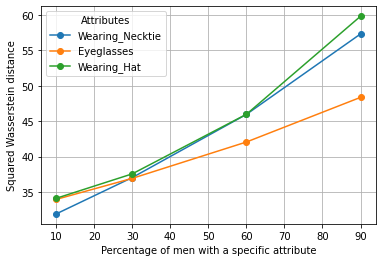

In [24]:
for attr, scores in wasserstein.items():
    plt.plot([10,30,60,90], scores, "-o")

plt.title("")
plt.xlabel("Percentage of men with a specific attribute")
plt.ylabel("Squared Wasserstein distance")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.savefig("../results/Experiment1/Wasserstein_distance_plot.png")
plt.show()

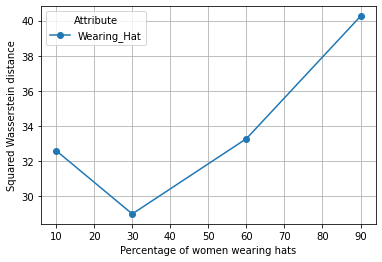

In [30]:
fem_hat_csvs = ["../data/celeba/experiment1_Female_Wearing_Hat_{}%.csv".format(n) for n in [10,30,60,90]]
fem_hat_dfs = [pd.read_csv(path) for path in fem_hat_csvs]
scores = [compute_wasserstein(df, "values_resnet18") for df in fem_hat_dfs]

plt.plot([10,30,60,90], scores, "-o")

plt.title("")
plt.xlabel("Percentage of women wearing hats")
plt.ylabel("Squared Wasserstein distance")
plt.legend(["Wearing_Hat"], title="Attribute")
plt.grid()

plt.savefig("../results/Experiment1/Female_Hats_Wasserstein_distance_plot.png")
plt.show()

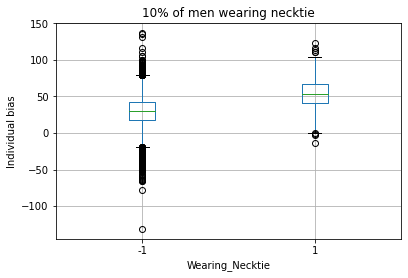

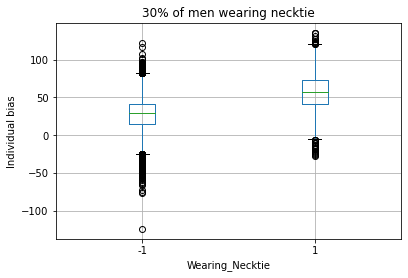

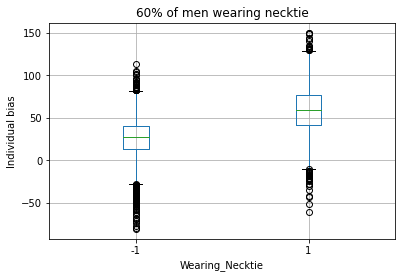

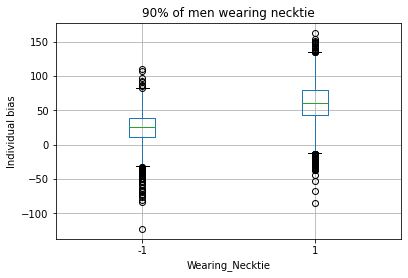

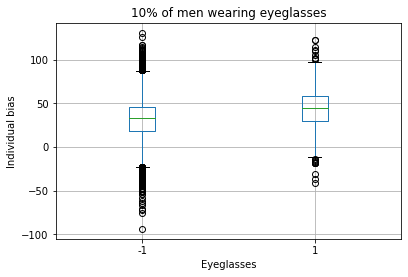

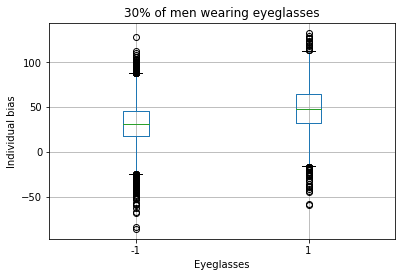

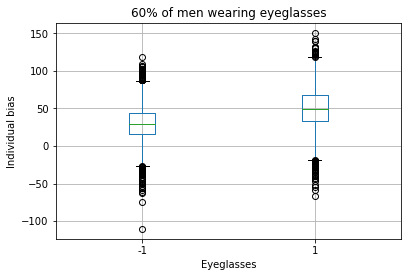

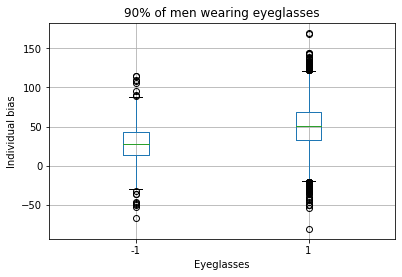

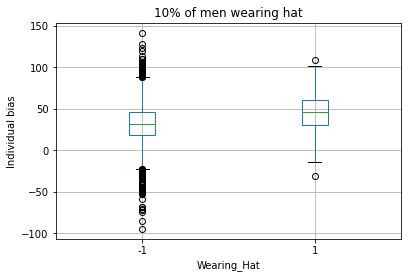

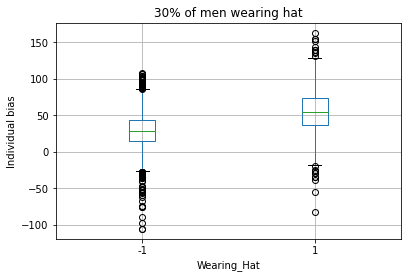

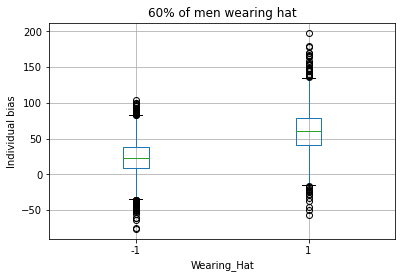

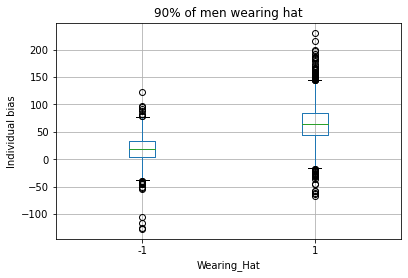

In [37]:
for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        box_plot(dataframes[attr][i], n, attr, "values_resnet18")

In [65]:
attributes_list = list()
perc = [10,30,60,90] * 3
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        df = dataframes[attr][i]
        col1 = df[df[attr] == 1].values_resnet18
        col2 = df[df[attr] == -1].values_resnet18
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [66]:
print(table.set_index(["attribute", "percentage"]).to_latex())

\begin{tabular}{llrr}
\toprule
            &    &  statistic &    pvalue \\
attribute & percentage &            &           \\
\midrule
Wearing\_Necktie & 10 &   0.000227 &  0.999698 \\
            & 30 &   0.000000 &  1.000000 \\
            & 60 &   0.000000 &  1.000000 \\
            & 90 &   0.000000 &  1.000000 \\
Eyeglasses & 10 &   0.000212 &  0.999760 \\
            & 30 &   0.000000 &  1.000000 \\
            & 60 &   0.000000 &  1.000000 \\
            & 90 &   0.000106 &  0.999901 \\
Wearing\_Hat & 10 &   0.001617 &  0.995591 \\
            & 30 &   0.000000 &  1.000000 \\
            & 60 &   0.000000 &  1.000000 \\
            & 90 &   0.000000 &  1.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2435927/2333445097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.set_index(["attribute", "percentage"]).to_latex())
